# Terrain

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/particles/Terrain.ipynb)

This example simulates particles moving on the surface of a terrain defined by a heightmap.

In [1]:
%pip install --quiet phiflow
from phi.torch.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange
from PIL import Image
# %matplotlib widget

Let's import a terrain height map from an image using the `PIL` library.
Once loaded, we can construct a `Heightmap` which we can later query for collisions.

<Figure size 864x360 with 1 Axes>

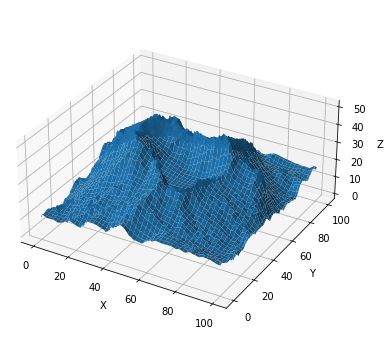

In [63]:
im_frame = Image.open("Terrain003_2K.png")
height_2k = tensor(np.array(im_frame), spatial('y,x'))
height = math.downsample2x(math.downsample2x(height_2k)) / height_2k.max * 50
bounds = Box(x=100, y=100, z=50)
terrain = geom.Heightmap(height, bounds, max_dist=.5)
plot(terrain)

Now let's place some balls on top of the terrain.

<Figure size 864x360 with 1 Axes>

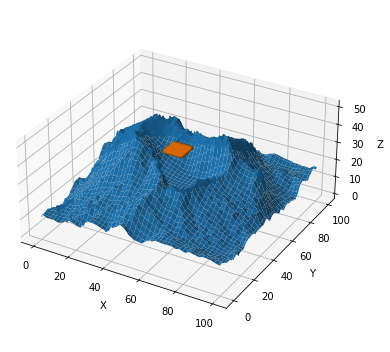

In [55]:
x0 = CenteredGrid(0, x=10, y=10, z=1, bounds=Cuboid(vec(x=60, y=30, z=50), x=10, y=10, z=1).corner_representation()).as_points().points
balls = Sphere(x0, radius=1)
v0 = math.zeros_like(balls.center)
plot([terrain, balls], overlay='list', color=[0, 1], plt_params={'z-order': 'as-provided'})

In each update, we want the balls to be affected by gravity.
We store the velocities in the `values` of the field and the positions in its `geometry`.
To detect collisions with the terrain, we query the `approximate_closest_surface` to obtain the distance and surface normal.

In [64]:
@jit_compile
def step(balls: Field, dt, elasticity=.4, gravity=vec(x=0, y=0, z=-9.81)):
    v = balls.values + dt * gravity
    dist, _, normal, *_ = terrain.approximate_closest_surface(balls.points)
    bounce = (dist < balls.geometry.bounding_radius()) & (v.vector @ normal < 0)
    impact = -(1+elasticity) * (v.vector @ normal.vector) * normal
    v = math.where(bounce, v + impact, v)
    x = math.clip(balls.points + dt * v, bounds.lower, bounds.upper)
    return balls.shifted_to(x).with_values(v)

Now let's run the simulation for some steps.

In [67]:
ball_trj = iterate(step, batch(time=50), PointCloud(balls, v0), dt=.1, range=trange, substeps=2)

  0%|          | 0/50 [00:00<?, ?it/s]

In [72]:
plot([terrain, ball_trj.geometry], overlay='list', color=[0, 1], animate='time', plt_params={'z-order': 'as-provided'})